## Some theoratical information

### MFCCS- mel- frequency cepstrum coefficients

### Computing the cepstrum:

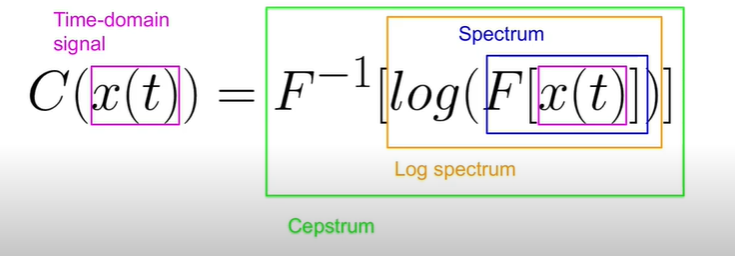

### We're basically trasforming our sound wave to an absolute formation, then create a log which allows us to see the signal's Frequency VS it's Magnitude and allows us to examine periodicities and general trend as well. Lastly were performing an inverse transformation which results in a general spectrum of the signal (Quefrency VS Magnitude).

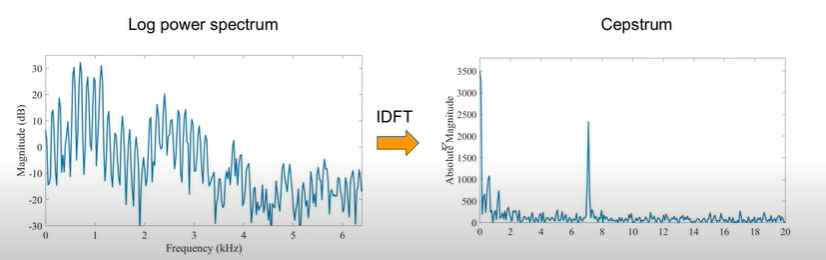

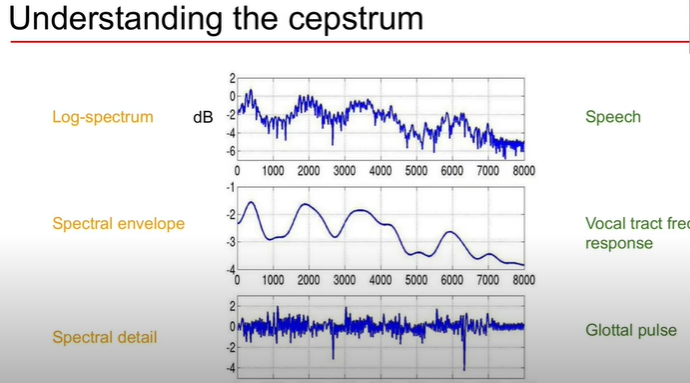

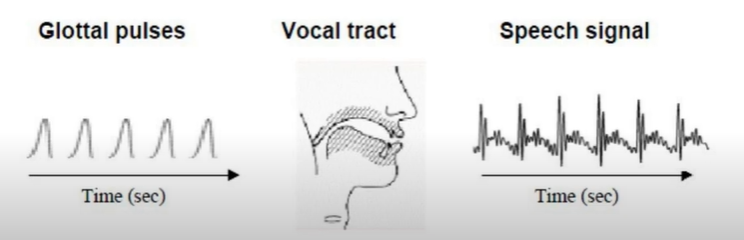

### Speech = Convolution of vocal tract frequency response and Glottal pulse.

### We are mostly interested in the Vocal tract, which contains the main knowledge that helps us understand our data (formants), and therefore we're looking for a way to seperate the Vocal tract from the Speech wave without having the Glottal pulse as well. We do that by applying a logarithm on the amplitude (audio is perceived logarithmically and not linearly), mel-scaling, and then a transformation (Discrete cosine transform).

### Our result- the waves coefficients! (MFCCS)

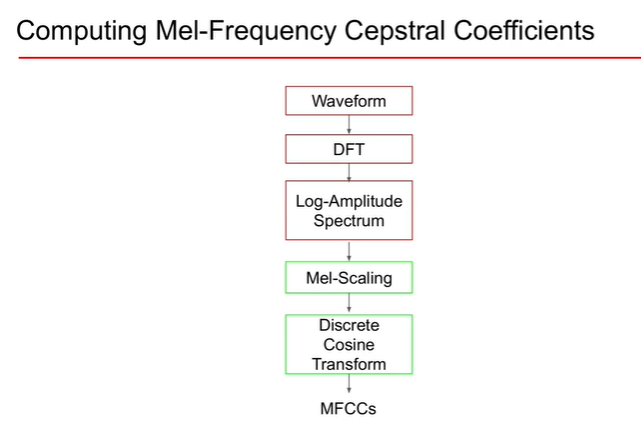

### Sources:

- https://www.microsoft.com/en-us/research/wp-content/uploads/2016/02/CNN_ASLPTrans2-14.pdf


### RAVDESS- File Summary

#### In total, the RAVDESS collection includes 7356 files (2880+2024+1440+1012 files).

#### File naming convention

##### Each of the 7356 RAVDESS files has a unique filename. The filename consists of a 7-part numerical identifier (e.g., 02-01-06-01-02-01-12.mp4). These identifiers define the stimulus characteristics: 

#### Filename identifiers 

* Modality (01 = full-AV, 02 = video-only, 03 = audio-only).
* Vocal channel (01 = speech, 02 = song).
* Emotion (01 = neutral, 02 = calm, 03 = happy, 04 = sad, 05 = angry, 06 = fearful, 07 = disgust, 08 = surprised).
* Emotional intensity (01 = normal, 02 = strong). NOTE: There is no strong intensity for the 'neutral' emotion.
* Statement (01 = "Kids are talking by the door", 02 = "Dogs are sitting by the door").
* Repetition (01 = 1st repetition, 02 = 2nd repetition).
* Actor (01 to 24. Odd numbered actors are male, even numbered actors are female).

  Filename example: 02-01-06-01-02-01-12.mp4 

* Video-only (02)
* Speech (01)
* Fearful (06)
* Normal intensity (01)
* Statement "dogs" (02)
* 1st Repetition (01)
* 12th Actor (12)
* Female, as the actor ID number is even.

## Import libraries

In [1]:
import os
import librosa
import numpy as np
from tqdm.notebook import tqdm
import pandas as pd
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings("ignore")
import seaborn as sns
sns.set_style('whitegrid')
import IPython.display as ipd
import librosa.display
import numpy as np
import cv2
import pickle

from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.pipeline import make_pipeline
from sklearn.cluster import KMeans
from sklearn.metrics import accuracy_score, confusion_matrix
from scipy.cluster.hierarchy import dendrogram
from sklearn.cluster import AgglomerativeClustering

from tqdm.notebook import tqdm

import tensorflow as tf
from tensorflow.keras.layers import Dense, Dropout, Conv2D, AveragePooling1D, MaxPooling2D, Flatten
from tensorflow.keras.optimizers import SGD
from tensorflow.keras.models import Sequential
from tensorflow.keras import layers

# from livelossplot import PlotLossesKeras
tf.config.list_physical_devices('GPU')

[]

## Get data from datasets:

In [2]:
main_path = 'D://emotion_recognition_data'
TESS = os.path.join(main_path, "data3/")
RAV = os.path.join(main_path, "data/")
SAVEE = os.path.join(main_path, "data2/")

dir_list = os.listdir(SAVEE)
dir_list[0:5]

['DC_a01.wav', 'DC_a02.wav', 'DC_a03.wav', 'DC_a04.wav', 'DC_a05.wav']

### RAVDESS dataset

In [3]:
lst = []
emotion = []
voc_channel = []
full_path = []
modality = []
intensity = []
actors = []
phrase =[]

for root, dirs, files in tqdm(os.walk(RAV)):
    for file in files:
        try:
            #Load librosa array, obtain mfcss, store the file and the mfcss information in a new array
            # X, sample_rate = librosa.load(os.path.join(root,file), res_type='kaiser_fast')
            # mfccs = np.mean(librosa.feature.mfcc(y=X, sr=sample_rate, n_mfcc=40).T,axis=0) 
            # The instruction below converts the labels (from 1 to 8) to a series from 0 to 7
            # This is because our predictor needs to start from 0 otherwise it will try to predict also 0.
           
            modal = int(file[1:2])
            vchan = int(file[4:5])
            lab = int(file[7:8])
            ints = int(file[10:11])
            phr = int(file[13:14])
            act = int(file[19:20])
            
            # arr = mfccs, lab
            # lst.append(arr)
            
            modality.append(modal)
            voc_channel.append(vchan)
            emotion.append(lab) #only labels
            intensity.append(ints)
            phrase.append(phr)
            actors.append(act)
            
            full_path.append((root, file)) # only files
          # If the file is not valid, skip it
        except ValueError:
            continue

0it [00:00, ?it/s]

In [4]:
# 01 = neutral, 02 = calm, 03 = happy, 04 = sad, 05 = angry, 06 = fearful, 07 = disgust, 08 = surprised
emotions_list = ['neutral', 'calm', 'happy', 'sad', 'angry', 'fearful', 'disgust', 'surprised']
emotion_dict = {em[0]+1:em[1] for em in enumerate(emotions_list)}

df = pd.DataFrame([emotion, voc_channel, modality, intensity, actors, phrase, full_path]).T
df.columns = ['emotion', 'voc_channel', 'modality', 'intensity', 'actors', 'phrase', 'path']
df['emotion'] = df['emotion'].map(emotion_dict)
df['voc_channel'] = df['voc_channel'].map({1: 'speech', 2:'song'})
df['modality'] = df['modality'].map({1: 'full AV', 2:'video only', 3:'audio only'})
df['intensity'] = df['intensity'].map({1: 'normal', 2:'strong'})
df['actors'] = df['actors'].apply(lambda x: 'female' if x%2 == 0 else 'male')
df['phrase'] = df['phrase'].map({1: 'Kids are talking by the door', 2:'Dogs are sitting by the door'})
df['path'] = df['path'].apply(lambda x: x[0] + '/' + x[1])


In [5]:
df.head()

,emotion,voc_channel,modality,intensity,actors,phrase,path
0,neutral,speech,audio only,normal,male,Kids are talking by the door,D://emotion_recognition_data\data/data\Actor_0...
1,neutral,speech,audio only,normal,male,Kids are talking by the door,D://emotion_recognition_data\data/data\Actor_0...
2,neutral,speech,audio only,normal,male,Dogs are sitting by the door,D://emotion_recognition_data\data/data\Actor_0...
3,neutral,speech,audio only,normal,male,Dogs are sitting by the door,D://emotion_recognition_data\data/data\Actor_0...
4,calm,speech,audio only,normal,male,Kids are talking by the door,D://emotion_recognition_data\data/data\Actor_0...


### SAVEE

In [6]:
# Get the data location for SAVEE
dir_list = os.listdir(SAVEE)

# parse the filename to get the emotions
emotion=[]
path = []
for i in dir_list:
    if i[-8:-6]=='_a':
        emotion.append('angry_male')
    elif i[-8:-6]=='_d':
        emotion.append('disgust_male')
    elif i[-8:-6]=='_f':
        emotion.append('fear_male')
    elif i[-8:-6]=='_h':
        emotion.append('happy_male')
    elif i[-8:-6]=='_n':
        emotion.append('neutral_male')
    elif i[-8:-6]=='sa':
        emotion.append('sad_male')
    elif i[-8:-6]=='su':
        emotion.append('surprise_male')
    else:
        emotion.append('Unknown') 
    path.append(SAVEE + i)
    
# Now check out the label count distribution 
SAVEE_df = pd.DataFrame(emotion, columns = ['emotion_label'])
SAVEE_df['source'] = 'SAVEE'
SAVEE_df = pd.concat([SAVEE_df, pd.DataFrame(path, columns = ['path'])], axis = 1)
SAVEE_df.emotion_label.value_counts()

neutral_male     120
happy_male        60
disgust_male      60
sad_male          60
fear_male         60
angry_male        60
surprise_male     60
Name: emotion_label, dtype: int64

In [7]:
SAVEE_df.head()

,emotion_label,source,path
0,angry_male,SAVEE,D://emotion_recognition_data\data2/DC_a01.wav
1,angry_male,SAVEE,D://emotion_recognition_data\data2/DC_a02.wav
2,angry_male,SAVEE,D://emotion_recognition_data\data2/DC_a03.wav
3,angry_male,SAVEE,D://emotion_recognition_data\data2/DC_a04.wav
4,angry_male,SAVEE,D://emotion_recognition_data\data2/DC_a05.wav


### TESS dataset

In [8]:
dir_list = os.listdir(TESS)
dir_list.sort()
dir_list

path = []
emotion = []

for i in dir_list:
    fname = os.listdir(TESS + i)
    for f in fname:
        if i == 'OAF_angry' or i == 'YAF_angry':
            emotion.append('angry_female')
        elif i == 'OAF_disgust' or i == 'YAF_disgust':
            emotion.append('disgust_female')
        elif i == 'OAF_Fear' or i == 'YAF_fear':
            emotion.append('fear_female')
        elif i == 'OAF_happy' or i == 'YAF_happy':
            emotion.append('happy_female')
        elif i == 'OAF_neutral' or i == 'YAF_neutral':
            emotion.append('neutral_female')                                
        elif i == 'OAF_Pleasant_surprise' or i == 'YAF_pleasant_surprised':
            emotion.append('surprise_female')               
        elif i == 'OAF_Sad' or i == 'YAF_sad':
            emotion.append('sad_female')
        else:
            emotion.append('Unknown')
        path.append(TESS + i + "/" + f)

TESS_df = pd.DataFrame(emotion, columns = ['emotion_label'])
TESS_df['source'] = 'TESS'
TESS_df = pd.concat([TESS_df,pd.DataFrame(path, columns = ['path'])],axis=1)
TESS_df.emotion_label.value_counts()

neutral_female     400
fear_female        400
sad_female         400
disgust_female     400
happy_female       400
surprise_female    400
angry_female       400
Unknown             14
Name: emotion_label, dtype: int64

In [9]:
TESS_df.head()

,emotion_label,source,path
0,fear_female,TESS,D://emotion_recognition_data\data3/OAF_Fear/OA...
1,fear_female,TESS,D://emotion_recognition_data\data3/OAF_Fear/OA...
2,fear_female,TESS,D://emotion_recognition_data\data3/OAF_Fear/OA...
3,fear_female,TESS,D://emotion_recognition_data\data3/OAF_Fear/OA...
4,fear_female,TESS,D://emotion_recognition_data\data3/OAF_Fear/OA...


### Combining the datasets:

In [10]:
RAV_df = df.copy()

# only speech
RAV_df = RAV_df.loc[RAV_df.voc_channel == 'speech']

RAV_df.insert(0, "emotion_label", RAV_df.emotion+'_'+RAV_df.actors, True)
RAV_df.insert(1, "source", "RAV", True)
RAV_df = RAV_df.drop(['emotion', 'voc_channel', 'modality', 'intensity', 'phrase'], 1)
RAV_df.head()

,emotion_label,source,actors,path
0,neutral_male,RAV,male,D://emotion_recognition_data\data/data\Actor_0...
1,neutral_male,RAV,male,D://emotion_recognition_data\data/data\Actor_0...
2,neutral_male,RAV,male,D://emotion_recognition_data\data/data\Actor_0...
3,neutral_male,RAV,male,D://emotion_recognition_data\data/data\Actor_0...
4,calm_male,RAV,male,D://emotion_recognition_data\data/data\Actor_0...


In [11]:
TESS_df.insert(2, "actors", "female", True)
SAVEE_df.insert(2, "actors", "male", True)

In [43]:
SAVEE_df['emotion_label'].unique()

array(['angry_male', 'disgust_male', 'fear_male', 'happy_male',
       'neutral_male', 'sad_male', 'surprise_male'], dtype=object)

In [12]:
df_combined = pd.concat([TESS_df, RAV_df, SAVEE_df])
df_combined.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 4734 entries, 0 to 479
Data columns (total 4 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   emotion_label  4734 non-null   object
 1   source         4734 non-null   object
 2   actors         4734 non-null   object
 3   path           4734 non-null   object
dtypes: object(4)
memory usage: 184.9+ KB


In [13]:
for col in ['emotion_label', 'source', 'actors']:
    print('\nColumn values for ', col.upper())
    print(df_combined[col].value_counts())


Column values for  EMOTION_LABEL
sad_female          496
disgust_female      496
happy_female        496
angry_female        496
neutral_female      448
surprise_female     400
fear_female         400
neutral_male        168
angry_male          156
sad_male            156
disgust_male        156
happy_male          156
surprised_male       96
surprised_female     96
calm_female          96
fearful_male         96
fearful_female       96
calm_male            96
fear_male            60
surprise_male        60
Unknown              14
Name: emotion_label, dtype: int64

Column values for  SOURCE
TESS     2814
RAV      1440
SAVEE     480
Name: source, dtype: int64

Column values for  ACTORS
female    3534
male      1200
Name: actors, dtype: int64


In [14]:
new_labels_dict_comb = {'angry_male':'negative_male', 'angry_female':'negative_female', 
                        'calm_male':'neutral_male', 'calm_female':'neutral_female',
                        'disgust_male':'negative_male', 'disgust_female':'negative_female', 
                        'fearful_male':'negative_male','fearful_female':'negative_female',
                        'fear_male':'negative_male', 'fear_female':'negative_female',
                        'happy_male':'positive_male', 'happy_female':'positive_female',
                        'neutral_male':'neutral_male', 'neutral_female':'neutral_female',
                        'sad_male':'negative_male', 'sad_female':'negative_female',
                        'surprised_male':'positive_male', 'surprised_female':'positive_female',
                        'surprise_male':'positive_male', 'surprise_female':'positive_female',
                        'Unknown': 'unk'}

df_combined['emotion2'] = df_combined['emotion_label'].map(new_labels_dict_comb)
df_combined.head()

,emotion_label,source,actors,path,emotion2
0,fear_female,TESS,female,D://emotion_recognition_data\data3/OAF_Fear/OA...,negative_female
1,fear_female,TESS,female,D://emotion_recognition_data\data3/OAF_Fear/OA...,negative_female
2,fear_female,TESS,female,D://emotion_recognition_data\data3/OAF_Fear/OA...,negative_female
3,fear_female,TESS,female,D://emotion_recognition_data\data3/OAF_Fear/OA...,negative_female
4,fear_female,TESS,female,D://emotion_recognition_data\data3/OAF_Fear/OA...,negative_female


In [15]:
addit_labels_dict_comb = {'angry_male':'angry', 'angry_female':'angry', 
                        'calm_male':'neutral', 'calm_female':'neutral',
                        'disgust_male':'negative', 'disgust_female':'negative', 
                        'fearful_male':'fear','fearful_female':'fear',
                        'fear_male':'fear', 'fear_female':'fear',
                        'happy_male':'positive', 'happy_female':'positive',
                        'neutral_male':'neutral', 'neutral_female':'neutral',
                        'sad_male':'sadness', 'sad_female':'sadness',
                        'surprised_male':'surprise', 'surprised_female':'surprise',
                        'surprise_male':'surprise', 'surprise_female':'surprise',
                        'Unknown': 'unk'}

df_combined['emotion3'] = df_combined['emotion_label'].map(addit_labels_dict_comb)
df_combined.head()

,emotion_label,source,actors,path,emotion2,emotion3
0,fear_female,TESS,female,D://emotion_recognition_data\data3/OAF_Fear/OA...,negative_female,fear
1,fear_female,TESS,female,D://emotion_recognition_data\data3/OAF_Fear/OA...,negative_female,fear
2,fear_female,TESS,female,D://emotion_recognition_data\data3/OAF_Fear/OA...,negative_female,fear
3,fear_female,TESS,female,D://emotion_recognition_data\data3/OAF_Fear/OA...,negative_female,fear
4,fear_female,TESS,female,D://emotion_recognition_data\data3/OAF_Fear/OA...,negative_female,fear


In [17]:
df_combined.emotion2.value_counts()

negative_female    1984
positive_female     992
negative_male       624
neutral_female      544
positive_male       312
neutral_male        264
unk                  14
Name: emotion2, dtype: int64

In [18]:
df_combined.emotion3.value_counts()

neutral     808
surprise    652
angry       652
positive    652
fear        652
negative    652
sadness     652
unk          14
Name: emotion3, dtype: int64

In [19]:
df_combined = df_combined.loc[df_combined['emotion2'] != 'unk']

### Save the data:

In [23]:
df_combined.to_csv(os.path.join(main_path,"combined.csv"), index=False)

### (Using the combined DF, MFCC's and column 'emotion2' as target)

In [25]:
import pickle

df_path = 'D://emotion_recognition_data//combined.csv'
# mfccs_path = 'd://itc//final_project//mfccs.pickle'
# new_y_path = 'd://itc//final_project//y.pickle'

# with open('d://downloads//y.pickle', 'wb') as f:
#     pickle.dump(new_y, f)
    
# with open('d://downloads//mfccs.pickle', 'wb') as f:
#     pickle.dump(mfccs, f)

mydf = pd.read_csv(df_path)

# with open(mfccs_path, 'rb') as f:
#     mfccs = pickle.load(f)

# with open(new_y_path, 'rb') as f:
#     new_y = pickle.load(f)

### EDA

In [275]:
mydf.head()

,source,actors,path,emotion2,emotion3
0,TESS,female,D://emotion_recognition_data\data3/OAF_Fear/OA...,negative_female,fear
1,TESS,female,D://emotion_recognition_data\data3/OAF_Fear/OA...,negative_female,fear
2,TESS,female,D://emotion_recognition_data\data3/OAF_Fear/OA...,negative_female,fear
3,TESS,female,D://emotion_recognition_data\data3/OAF_Fear/OA...,negative_female,fear
4,TESS,female,D://emotion_recognition_data\data3/OAF_Fear/OA...,negative_female,fear


In [276]:
mydf.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4720 entries, 0 to 4719
Data columns (total 5 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   source    4720 non-null   object
 1   actors    4720 non-null   object
 2   path      4720 non-null   object
 3   emotion2  4720 non-null   object
 4   emotion3  4720 non-null   object
dtypes: object(5)
memory usage: 184.5+ KB


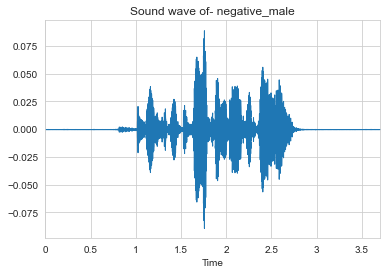

In [283]:
ind = np.random.randint(0,len(mydf))
data, sampling_rate = librosa.load(mydf['path'][ind], sr=44100)
emotion = mydf['emotion2'][ind]

plt.title(f'Sound wave of- {emotion}')
librosa.display.waveplot(data, sampling_rate)
plt.show()

#### Linear-scale spectrum

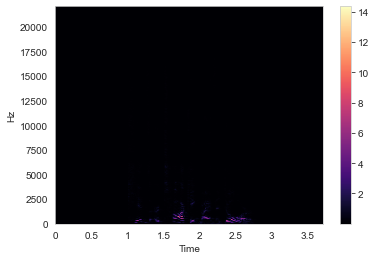

In [284]:
D = np.abs(librosa.stft(data))
librosa.display.specshow(D, sr=sampling_rate, x_axis='time', y_axis='linear');
plt.colorbar()
plt.show()

#### Log-scale Spectrogram

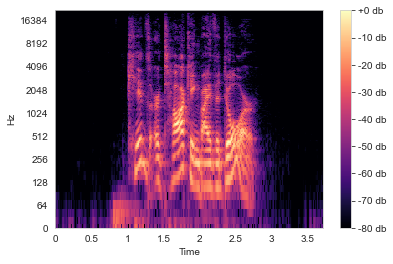

In [285]:
DB = librosa.amplitude_to_db(D, ref=np.max)
librosa.display.specshow(DB, sr=sampling_rate, x_axis='time', y_axis='log');
plt.colorbar(format='%+2.0f db')
plt.show()

#### Log-scale spectrum

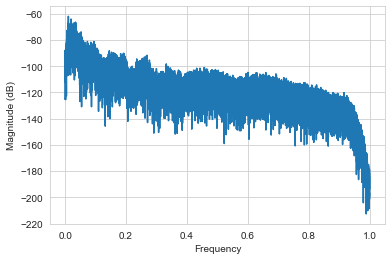

In [317]:
a = plt.magnitude_spectrum(data, scale='dB')
plt.show()

In [337]:
a1 = np.log(a[0])
a2 = a[1]

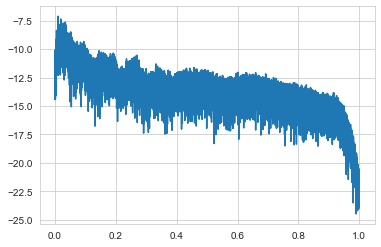

In [340]:
plt.plot(a2,a1)
plt.show()

In [341]:
def hl_envelopes_idx(s, dmin=1, dmax=1, split=False):
    """
    Input :
    s: 1d-array, data signal from which to extract high and low envelopes
    dmin, dmax: int, optional, size of chunks, use this if the size of the input signal is too big
    split: bool, optional, if True, split the signal in half along its mean, might help to generate the envelope in some cases
    Output :
    lmin,lmax : high/low envelope idx of input signal s
    """

    # locals min      
    lmin = (np.diff(np.sign(np.diff(s))) > 0).nonzero()[0] + 1 
    # locals max
    lmax = (np.diff(np.sign(np.diff(s))) < 0).nonzero()[0] + 1 
    

    if split:
        # s_mid is zero if s centered around x-axis or more generally mean of signal
        s_mid = np.mean(s) 
        # pre-sorting of locals min based on relative position with respect to s_mid 
        lmin = lmin[s[lmin]<s_mid]
        # pre-sorting of local max based on relative position with respect to s_mid 
        lmax = lmax[s[lmax]>s_mid]


    # global max of dmax-chunks of locals max 
    lmin = lmin[[i+np.argmin(s[lmin[i:i+dmin]]) for i in range(0,len(lmin),dmin)]]
    # global min of dmin-chunks of locals min 
    lmax = lmax[[i+np.argmax(s[lmax[i:i+dmax]]) for i in range(0,len(lmax),dmax)]]
    
    return lmin,lmax

In [344]:
data.shape

(163334,)

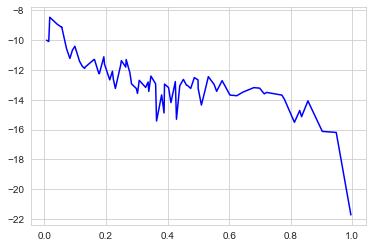

In [359]:
high_idx, _ = hl_envelopes_idx(data[:len(a1)], dmin=250)

# plot
plt.plot(a2[high_idx], a1[high_idx], 'b', label='low')
plt.show()

### Create DF from MFCC's and 'emotion2' columns as labels

In [26]:
new_y = mydf['emotion2'].copy()

In [4]:
X = []
for i in tqdm(mydf['path']):
    X.append(librosa.load(i, res_type='kaiser_fast', sr=44000))

  0%|          | 0/4720 [00:00<?, ?it/s]

In [5]:
new_x = []
for ind,i in enumerate(X):
    new_x.append(i[0])

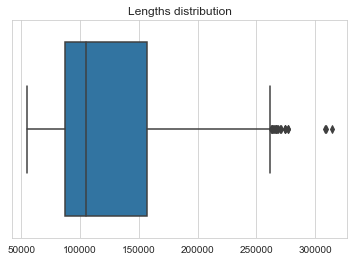

In [6]:
lengths = [len(x) for x in new_x]

plt.title('Lengths distribution')
sns.boxplot(lengths)
plt.show()

In [7]:
thresh = 300000

3


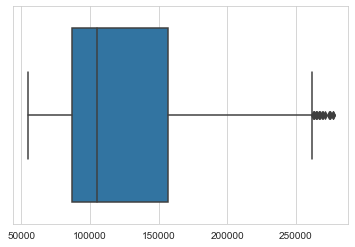

In [8]:
lengths = np.array(lengths)
print((lengths > thresh).sum())
new_lengths = lengths[lengths < thresh]

sns.boxplot(new_lengths)
plt.show()

In [9]:
new_lengths.mean()

120378.5976256095

In [10]:
length_chosen = 120378

In [11]:
import math

X_new = []
y_new = []
for ind,i in enumerate(new_x):
    if i.shape[0] < 300000:
        if i.shape[0] > length_chosen:
            new = i[:length_chosen]
            X_new.append(new)
        elif i.shape[0] < length_chosen:
            new = np.pad(i,math.ceil((length_chosen-i.shape[0])/2), mode='median')
            X_new.append(new)
        else:
            X_new.append(i)
            
        y_new.append(new_y[ind])
            

In [12]:
X = np.array(X_new)
y = np.array(y_new)
print(X.shape, y.shape)

(4717,) (4717,)


<ipython-input-12-c6c504f55594>:1: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  X = np.array(X_new)


In [13]:
mfccs = []
for i in tqdm(X):
    mfcc = librosa.feature.mfcc(y=i, sr=44000, n_mfcc=20)
    mfcc = mfcc.T
    mfccs.append(mfcc)


  0%|          | 0/4717 [00:00<?, ?it/s]

In [14]:
mfccs = np.array(mfccs)

In [360]:
mydf.shape, mfccs.shape, y.shape

((4720, 5), (4717, 236, 40), (4717,))

### Save the data:

In [16]:
mfccs_path = 'd://ITC//final_project//mfccs.pickle'
y_path = 'd://ITC//final_project//y.pickle'

with open(mfccs_path, 'wb') as f:
    pickle.dump(mfccs,f)
    
with open(y_path, 'wb') as f:
    pickle.dump(y,f)

# BASELINE MODEL

### At this point, we can perform a normal classification, using our mfccs coefficients as our features.

In [2]:
# random:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(mfccs, y, test_size=0.20)
X_train.shape, X_test.shape, y_train.shape, y_test.shape


### We'll change the values in our target variable and expand the dimension of our features to fit the neural networks.

In [18]:
from tensorflow.keras.models import Sequential
from tensorflow.keras import layers
from tensorflow.keras.layers import Dense

model = Sequential(
    [
     layers.Conv1D(64, 3, activation='relu', input_shape=(236,20)),
     layers.MaxPooling1D(),
     layers.Conv1D(64, 3, activation='relu'),
     layers.MaxPooling1D(),
     layers.Conv1D(64, 3, activation='relu'),
     layers.MaxPooling1D(),
     layers.Flatten(),
     layers.Dense(64, activation="relu"),
     layers.Dense(6, activation="softmax")
    ]
)


In [95]:
model.summary()

Model: "sequential_17"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_90 (Conv1D)           (None, 234, 64)           3904      
_________________________________________________________________
max_pooling1d_40 (MaxPooling (None, 117, 64)           0         
_________________________________________________________________
conv1d_91 (Conv1D)           (None, 115, 64)           12352     
_________________________________________________________________
max_pooling1d_41 (MaxPooling (None, 57, 64)            0         
_________________________________________________________________
conv1d_92 (Conv1D)           (None, 55, 64)            12352     
_________________________________________________________________
max_pooling1d_42 (MaxPooling (None, 27, 64)            0         
_________________________________________________________________
flatten_10 (Flatten)         (None, 1728)            

In [96]:
model.input_shape, model.output_shape

((None, 236, 20), (None, 6))

### Encoding the labels:

In [19]:
set(y)

{'negative_female',
 'negative_male',
 'neutral_female',
 'neutral_male',
 'positive_female',
 'positive_male'}

In [20]:
emotions_encode = {'negative_female':0, 'negative_male':1, 'neutral_female':2, 'neutral_male':3,
                  'positive_female':4, 'positive_male':5}

In [21]:
y_train = pd.Series(y_train).map(emotions_encode)
y_test = pd.Series(y_test).map(emotions_encode)

In [99]:
model.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics='accuracy')
model.fit(X_train, y_train, batch_size=16, epochs=50, validation_data=(X_test, y_test))

Epoch 1/50
236/236 [==============================] - 20s 13ms/step - loss: 5.8538 - accuracy: 0.4724 - val_loss: 0.6819 - val_accuracy: 0.7066
Epoch 2/50
236/236 [==============================] - 2s 10ms/step - loss: 0.5316 - accuracy: 0.7633 - val_loss: 0.4354 - val_accuracy: 0.7977
Epoch 3/50
236/236 [==============================] - 2s 10ms/step - loss: 0.4226 - accuracy: 0.8040 - val_loss: 0.4130 - val_accuracy: 0.8030
Epoch 4/50
236/236 [==============================] - 2s 10ms/step - loss: 0.3744 - accuracy: 0.8267 - val_loss: 0.4577 - val_accuracy: 0.7977
Epoch 5/50
236/236 [==============================] - 2s 10ms/step - loss: 0.3433 - accuracy: 0.8393 - val_loss: 0.3599 - val_accuracy: 0.8263
Epoch 6/50
236/236 [==============================] - 2s 10ms/step - loss: 0.2857 - accuracy: 0.8825 - val_loss: 0.4165 - val_accuracy: 0.8189
Epoch 7/50
236/236 [==============================] - 2s 10ms/step - loss: 0.3498 - accuracy: 0.8473 - val_loss: 0.3270 - val_accuracy: 0.861

In [29]:
from sklearn.metrics import classification_report

y_pred = model.predict(X_test)
y_pred = [np.argmax(x) for x in y_pred]
print(classification_report(y_test, y_pred, target_names = list(emotions_encode.keys())))

In [72]:
mydf['emotion2'].unique()

array(['negative_female', 'positive_female', 'neutral_female',
       'neutral_male', 'positive_male', 'negative_male'], dtype=object)

In [22]:
import tensorflow as tf

model2 = Sequential()

model2.add(layers.Conv1D(256, 5,padding='same',
                 input_shape=(236,20)))
model2.add(layers.Activation('relu'))
model2.add(layers.MaxPooling1D(pool_size=(8)))
model2.add(layers.Dropout(0.1))

model2.add(layers.Conv1D(128, 5,padding='same'))
model2.add(layers.Activation('relu'))
model2.add(layers.Dropout(0.1))

model2.add(layers.Flatten())
model2.add(layers.Dense(6))
model2.add(layers.Activation('softmax'))

model2.summary()


Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d (Conv1D)              (None, 236, 256)          25856     
_________________________________________________________________
activation (Activation)      (None, 236, 256)          0         
_________________________________________________________________
max_pooling1d (MaxPooling1D) (None, 29, 256)           0         
_________________________________________________________________
dropout (Dropout)            (None, 29, 256)           0         
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 29, 128)           163968    
_________________________________________________________________
activation_1 (Activation)    (None, 29, 128)           0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 29, 128)           0

In [16]:
reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_accuracy', 
                                                 factor=0.5, patience=4, 
                                                 verbose=1, mode='max', 
                                                 min_lr=0.00001)

early_stop = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=40, 
                                              verbose=1)

weight_path = 'd://ITC//final_project//best_weights.hdf5'
model_checkpoint = tf.keras.callbacks.ModelCheckpoint(filepath=weight_path, 
                                                      save_weights_only=True, 
                                                      monitor='val_accuracy', 
                                                      mode='max', 
                                                      save_best_only=True)


In [31]:
model2.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics='accuracy')
model2.fit(X_train, y_train, batch_size=16, epochs=500, validation_data=(X_test, y_test),
           callbacks=[reduce_lr, early_stop, model_checkpoint])

Epoch 1/500
236/236 [==============================] - 6s 25ms/step - loss: 0.0031 - accuracy: 0.9989 - val_loss: 0.7180 - val_accuracy: 0.8972
Epoch 2/500
236/236 [==============================] - 6s 24ms/step - loss: 0.0041 - accuracy: 0.9984 - val_loss: 0.7073 - val_accuracy: 0.8941
Epoch 3/500
236/236 [==============================] - 6s 24ms/step - loss: 0.0095 - accuracy: 0.9979 - val_loss: 0.7165 - val_accuracy: 0.8941
Epoch 4/500
236/236 [==============================] - 6s 24ms/step - loss: 0.0054 - accuracy: 0.9979 - val_loss: 0.7106 - val_accuracy: 0.8909
Epoch 5/500
236/236 [==============================] - 6s 25ms/step - loss: 0.0034 - accuracy: 0.9987 - val_loss: 0.7105 - val_accuracy: 0.8919
Epoch 6/500
236/236 [==============================] - 6s 24ms/step - loss: 0.0030 - accuracy: 0.9992 - val_loss: 0.7163 - val_accuracy: 0.8909
Epoch 7/500
236/236 [==============================] - 6s 25ms/step - loss: 0.0047 - accuracy: 0.9979 - val_loss: 0.7203 - val_accuracy:

KeyboardInterrupt: 

In [32]:
model2.load_weights('d://ITC//final_project//best_weights.hdf5')

In [33]:
y_pred = model2.predict(X_test)
y_pred = [np.argmax(x) for x in y_pred]
print(classification_report(y_test, y_pred, target_names = list(emotions_encode.keys())))

                 precision    recall  f1-score   support

negative_female       0.96      0.98      0.97       396
  negative_male       0.73      0.74      0.74       138
 neutral_female       0.99      0.94      0.97       104
   neutral_male       0.80      0.77      0.79        57
positive_female       0.97      0.97      0.97       190
  positive_male       0.59      0.58      0.58        59

       accuracy                           0.90       944
      macro avg       0.84      0.83      0.83       944
   weighted avg       0.90      0.90      0.90       944



## Classifiy emotions- first we'll need to create new MFCC's and target arrays:

In [27]:
mydf['emotion3'].unique()

array(['fear', 'surprise', 'sadness', 'angry', 'negative', 'positive',
       'neutral'], dtype=object)

In [28]:
# mydf['emotion3'].replace(['fear_female', 'fear_male'], 'fear', inplace=True)
# mydf['emotion3'].replace(['surprise_female', 'surprise_male'], 'surprise', inplace=True)
# mydf['emotion3'].replace(['sad_female', 'sad_male'], 'sadness', inplace=True)
# mydf['emotion3'].replace(['negative_female', 'negative_male'], 'negetive', inplace=True)
# mydf['emotion3'].replace(['positive_female', 'positive_male'], 'positive', inplace=True)
# mydf['emotion3'].replace(['neutral_female', 'neutral_male'], 'neutral', inplace=True)

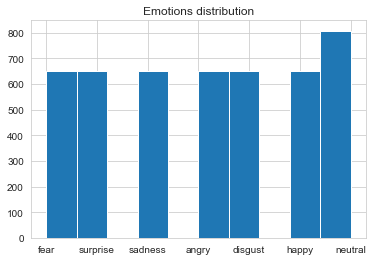

In [176]:
plt.title('Emotions distribution')
plt.hist(mydf['emotion3'])
# plt.hist(y)
plt.show()

In [44]:
y = mydf['emotion3'].copy()

In [45]:
mydf.head()

,emotion_label,source,actors,path,emotion2,emotion3
0,fear_female,TESS,female,D://emotion_recognition_data\data3/OAF_Fear/OA...,negative_female,fear
1,fear_female,TESS,female,D://emotion_recognition_data\data3/OAF_Fear/OA...,negative_female,fear
2,fear_female,TESS,female,D://emotion_recognition_data\data3/OAF_Fear/OA...,negative_female,fear
3,fear_female,TESS,female,D://emotion_recognition_data\data3/OAF_Fear/OA...,negative_female,fear
4,fear_female,TESS,female,D://emotion_recognition_data\data3/OAF_Fear/OA...,negative_female,fear


In [35]:
y.shape

(4720,)

In [36]:
X = []
for i in tqdm(mydf['path']):
    X.append(librosa.load(i, res_type='kaiser_fast', sr=44000))

  0%|          | 0/4720 [00:00<?, ?it/s]

In [46]:
new_x = []
for ind,i in enumerate(X):
    new_x.append(i[0])

In [47]:
lengths = [len(x) for x in new_x]

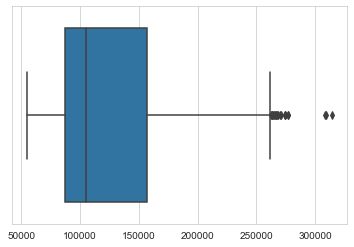

In [48]:
sns.boxplot(lengths)
plt.show()

3


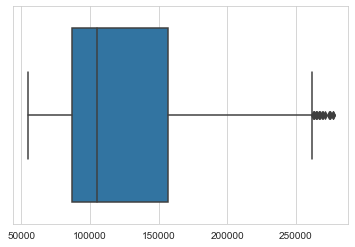

In [49]:
lengths = np.array(lengths)
print((lengths > 300000).sum())
new_lengths = lengths[lengths < 300000]

sns.boxplot(new_lengths)
plt.show()

In [50]:
print(new_lengths.mean())

120378.5976256095


In [186]:
length_chosen = 120378

In [52]:
import math

X_new = []
y_new = []
for ind,i in enumerate(new_x):
    if i.shape[0] < 300000:
        if i.shape[0] > length_chosen:
            new = i[:length_chosen]
            X_new.append(new)
        elif i.shape[0] < length_chosen:
            new = np.pad(i,math.ceil((length_chosen-i.shape[0])/2), mode='median')
            X_new.append(new)
        else:
            X_new.append(i)
            
        y_new.append(y[ind])
            

In [53]:
X = np.array(X_new)
y = np.array(y_new)
print(X.shape, y.shape)

(4717,) (4717,)


In [75]:
mfccs = []
for i in tqdm(X):
    mfcc = librosa.feature.mfcc(y=i, sr=44000, n_mfcc=40)
    mfcc = mfcc.T
    mfccs.append(mfcc)


  0%|          | 0/4717 [00:00<?, ?it/s]

In [76]:
mfccs = np.array(mfccs)
mfccs.shape

(4717, 236, 40)

In [77]:
set(y)

{'angry', 'fear', 'negative', 'neutral', 'positive', 'sadness', 'surprise'}

### Save new data:

In [144]:
import pickle 

mfccs2_path = 'D://emotion_recognition_data//mfccs2.pickle'
y2_path = 'D://emotion_recognition_data//y2.pickle'

# with open(mfccs2_path, 'wb') as f:
#     pickle.dump(mfccs,f)
    
# with open(y2_path, 'wb') as f:
#     pickle.dump(y,f)
    
with open(mfccs2_path, 'rb') as f:
    mfccs = pickle.load(f)
    
with open(y2_path, 'rb') as f:
    y = pickle.load(f)

In [145]:
set(y)

{'angry', 'fear', 'negative', 'neutral', 'positive', 'sadness', 'surprise'}

In [146]:
y = np.where(y=='positive', 'happy', y)
y = np.where(y=='negative', 'disgust', y)

In [147]:
emotion_enc = {'fear':0, 'disgust':1, 'neutral':2, 'happy':3, 'sadness':4, 'surprise':5, 'angry':6}

In [148]:
X_train, X_val, y_train, y_val = train_test_split(mfccs, y, test_size=0.2, random_state=12)
X_val, X_test, y_val, y_test = train_test_split(X_val, y_val, test_size=0.5, random_state=15)

X_train.shape, X_val.shape, X_test.shape, y_train.shape, y_val.shape, y_test.shape

((3773, 236, 40), (472, 236, 40), (472, 236, 40), (3773,), (472,), (472,))

In [149]:
y_train = pd.Series(y_train).map(emotion_enc)
y_val = pd.Series(y_val).map(emotion_enc)
y_test = pd.Series(y_test).map(emotion_enc)

In [150]:
y_train.unique(), y_test.unique(), y_val.unique()

(array([1, 0, 3, 2, 6, 4, 5], dtype=int64),
 array([2, 3, 0, 6, 4, 1, 5], dtype=int64),
 array([5, 3, 0, 1, 6, 4, 2], dtype=int64))

In [175]:
model3 = Sequential()

model3.add(layers.Conv1D(256, 5,padding='same',
                 input_shape=(236,40)))
model3.add(layers.Activation('relu'))
model3.add(layers.MaxPooling1D(pool_size=(8)))
model3.add(layers.Dropout(0.2))

model3.add(layers.Conv1D(128, 5,padding='same'))
model3.add(layers.Activation('relu'))
model3.add(layers.MaxPooling1D(pool_size=(4)))
model3.add(layers.Dropout(0.1))

model3.add(layers.Flatten())
model3.add(layers.Dense(64))
model3.add(layers.Dense(7))
model3.add(layers.Activation('softmax'))

model3.summary()


Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_6 (Conv1D)            (None, 236, 256)          25856     
_________________________________________________________________
activation_9 (Activation)    (None, 236, 256)          0         
_________________________________________________________________
max_pooling1d_6 (MaxPooling1 (None, 29, 256)           0         
_________________________________________________________________
dropout_6 (Dropout)          (None, 29, 256)           0         
_________________________________________________________________
conv1d_7 (Conv1D)            (None, 29, 128)           163968    
_________________________________________________________________
activation_10 (Activation)   (None, 29, 128)           0         
_________________________________________________________________
max_pooling1d_7 (MaxPooling1 (None, 7, 128)           

In [85]:
# weight_path2 = 'd://ITC//final_project_data//best_weights3.hdf5'
weight_path2 = 'D://emotion_recognition_data//best_weights2.hdf5'

reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_accuracy', 
                                                 factor=0.5, patience=4, 
                                                 verbose=1, mode='max', 
                                                 min_lr=0.00001)

early_stop = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=45, 
                                              verbose=1)

model_checkpoint2 = tf.keras.callbacks.ModelCheckpoint(filepath=weight_path2, 
                                                      save_weights_only=True, 
                                                      monitor='val_accuracy', 
                                                      mode='max', 
                                                      save_best_only=True)


In [86]:
model3.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics='accuracy')
model3.fit(X_train, y_train, batch_size=16, epochs=500, validation_data=(X_val, y_val),
           callbacks=[reduce_lr, early_stop, model_checkpoint2])

Epoch 1/500
236/236 [==============================] - 17s 31ms/step - loss: 25.0446 - accuracy: 0.2995 - val_loss: 1.0389 - val_accuracy: 0.5847
Epoch 2/500
236/236 [==============================] - 7s 30ms/step - loss: 1.0493 - accuracy: 0.6010 - val_loss: 0.8458 - val_accuracy: 0.6801
Epoch 3/500
236/236 [==============================] - 7s 30ms/step - loss: 0.9008 - accuracy: 0.6405 - val_loss: 0.7839 - val_accuracy: 0.6801
Epoch 4/500
236/236 [==============================] - 7s 29ms/step - loss: 0.8338 - accuracy: 0.6835 - val_loss: 0.7683 - val_accuracy: 0.6843
Epoch 5/500
236/236 [==============================] - 7s 30ms/step - loss: 0.7984 - accuracy: 0.6956 - val_loss: 0.7995 - val_accuracy: 0.6949
Epoch 6/500
236/236 [==============================] - 7s 29ms/step - loss: 0.7747 - accuracy: 0.7052 - val_loss: 0.7707 - val_accuracy: 0.6864
Epoch 7/500
236/236 [==============================] - 7s 29ms/step - loss: 0.7779 - accuracy: 0.6999 - val_loss: 0.7753 - val_accurac

In [87]:
# model3.load_weights(weight_path2)

## Transfer learning

In [269]:
# pretrained_model = tf.keras.applications.DenseNet201(include_top=False, 
#                                                      weights='imagenet', 
#                                                      input_shape=(236,40,3))
# # pretrained_model.trainable = False
# for layer in pretrained_model.layers:
#   if 'conv5' in layer.name:
#     layer.trainable = True
#   else:
#     layer.trainable = False

# pretrained_model.input_shape, pretrained_model.output_shape

In [270]:
# X_train.shape

In [271]:
# X_train_expand = np.expand_dims(X_train, 3)
# X_test_expand = np.expand_dims(X_test, 3)

In [28]:
# X_train_expand.shape, X_test_expand.shape

In [27]:
# before_model = Sequential()

# before_model.add(layers.Conv1D(256, 5,padding='same',
#                  input_shape=(236,40,1)))
# before_model.add(layers.Activation('relu'))
# before_model.add(layers.Dropout(0.2))
# # before_model.add(layers.UpSampling2D(size=2))
# before_model.add(layers.Dense(64))
# before_model.add(layers.Dense(3))

# before_model.summary()

In [26]:
# after_model = tf.keras.models.Sequential()
# after_model.add(before_model)
# after_model.add(pretrained_model)
# after_model.add(tf.keras.layers.GlobalAveragePooling2D())
# after_model.add(tf.keras.layers.Flatten())

# after_model.add(tf.keras.layers.Dense(256))
# after_model.add(tf.keras.layers.Dropout(0.2))

# after_model.add(tf.keras.layers.Dense(128))
# after_model.add(tf.keras.layers.Dropout(0.1))
# after_model.add(tf.keras.layers.Dense(6, activation='softmax'))

# after_model.summary()

In [25]:
# after_model.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics='accuracy')
# after_model.fit(X_train_expand, y_train, batch_size=32, epochs=500, validation_data=(X_test_expand, y_test),
#            callbacks=[reduce_lr, early_stop, model_checkpoint2])

### Final evaluation:

In [152]:
def report_res_and_plot_matrix(y_test, y_pred, plot_classes):

  #report metrics
  acc = accuracy_score(y_test, y_pred)
  print(f"Accuracy: {acc:.4f}")
  # print(f"Classes: {plot_classes}")

  #plot matrix
  cnf_matrix = confusion_matrix(y_test, y_pred)
  fig, ax = plt.subplots()
    
  tick_marks = np.arange(len(plot_classes))
  plt.xticks(ticks=tick_marks, labels=plot_classes, rotation=90)
  plt.yticks(ticks=tick_marks, labels=plot_classes, rotation=90)

  group_counts = [f'{value:0.0f}' for value in cnf_matrix.flatten()]
  group_percentages = [f'{100 * value:0.1f} %' for value in 
                       cnf_matrix.flatten()/np.sum(cnf_matrix)]
  labels = [f'{v1}\n({v2})' for v1, v2 in
            zip(group_counts,group_percentages)]
  n = int(np.sqrt(len(labels)))
  labels = np.asarray(labels).reshape(n,n)
  sns.heatmap(cnf_matrix, annot=labels, fmt='', cmap='Blues',
              xticklabels=plot_classes, yticklabels=plot_classes)


  ax.xaxis.set_label_position("bottom")
  plt.tight_layout()
  plt.title('Confusion matrix', y=1.1)
  plt.ylabel('Actual label')
  plt.xlabel('Predicted label')
  plt.show()

  # return metrics
  return [acc, cnf_matrix]

              precision    recall  f1-score   support

        fear       0.83      0.83      0.83        75
     disgust       0.85      0.89      0.87        57
     neutral       0.82      0.91      0.86        76
       happy       0.78      0.88      0.83        60
     sadness       0.84      0.79      0.82        67
    surprise       0.94      0.84      0.89        69
       angry       0.92      0.81      0.86        68

    accuracy                           0.85       472
   macro avg       0.85      0.85      0.85       472
weighted avg       0.85      0.85      0.85       472

Accuracy: 0.8496


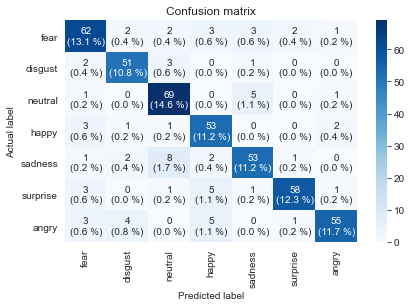

In [180]:
from sklearn.metrics import classification_report

y_pred = model3.predict(X_test).argmax(axis=1)

print(classification_report(y_test, y_pred, target_names=list(emotion_enc.keys())))
params = report_res_and_plot_matrix(y_test, y_pred, list(emotion_enc.keys()))

### Visualization of our classes

In [155]:
X_test.shape, X_train.shape, y_pred.shape

((472, 236, 40), (3773, 236, 40), (472,))

In [156]:
X_test_new = X_test.reshape(472,-1).copy()
X_train_new = X_train.reshape(3773,-1).copy()

In [157]:
X_test_new.shape, X_train_new.shape

((472, 9440), (3773, 9440))

In [158]:
from sklearn.preprocessing import StandardScaler, MinMaxScaler

scaler = StandardScaler()
scaler.fit(X_train_new)
X_train_scaled = scaler.transform(X_train_new)
X_test_scaled = scaler.transform(X_test_new)


In [159]:
from sklearn.decomposition import PCA

pca = PCA(n_components=2)
pca.fit_transform(X_train_scaled)
X_pca = pca.transform(X_test_scaled)


In [160]:
from sklearn.cluster import KMeans

kmeans = KMeans(n_clusters=7, random_state=0).fit(X_pca)
labels = kmeans.labels_

In [161]:
set(labels)

{0, 1, 2, 3, 4, 5, 6}

### Figuring out which label resambles which class:

In [162]:
set(y_pred)

{0, 1, 2, 3, 4, 5, 6}

In [163]:
l = pd.get_dummies(labels)
p = pd.get_dummies(y_pred)

l.shape, p.shape

((472, 7), (472, 7))

In [164]:
h = pd.merge(l, p, left_index=True, right_index=True)

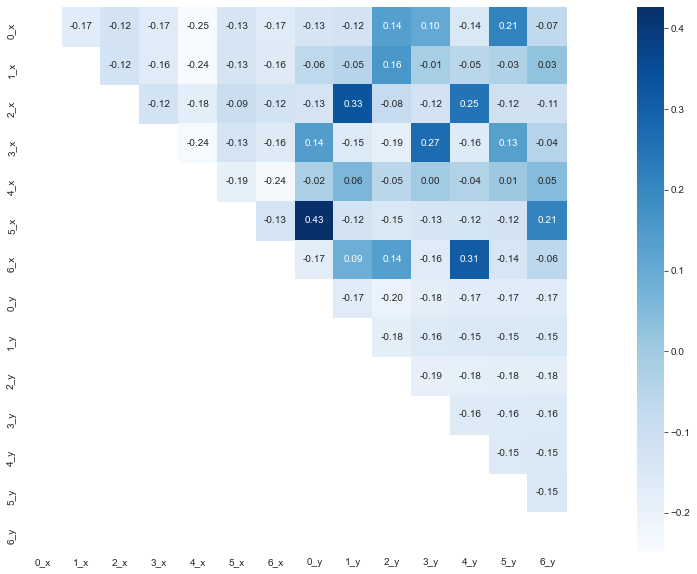

In [165]:
corr = h.corr(method='spearman')
mask = np.tril(np.ones_like(corr, dtype=np.bool))
ax = plt.figure(figsize=(25,10))
ax = sns.heatmap(h.corr(method='spearman'), annot=True, fmt=".2f", mask = mask, square = True, cmap="Blues")

In [166]:
a = pd.DataFrame(labels)
b= pd.DataFrame(y_pred)
c= pd.DataFrame()
c['labels'] = a[0].copy()
c['preds'] = b[0].copy()

In [167]:
c.head()

,labels,preds
0,4,2
1,1,2
2,3,3
3,4,0
4,3,6


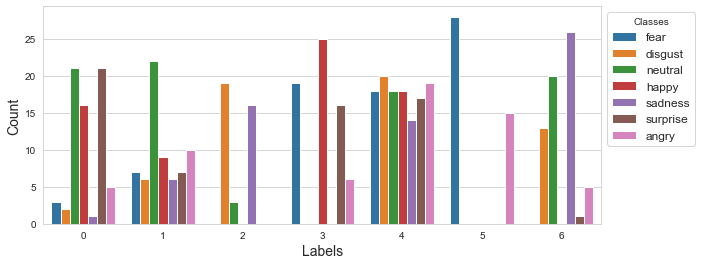

In [168]:
plt.figure(figsize=(10,4))
sns.countplot(x='labels', hue="preds", data=c)
plt.xlabel('Labels', fontsize=14)
plt.ylabel('Count', fontsize=14)
plt.legend(title='Classes', bbox_to_anchor = (1,1), labels=list(emotion_enc.keys()), fontsize='large')
plt.show()

### Corresponding classes:

- label 0 - class 5
- label 1 - class 2
- label 2 - class 1
- label 3 - class 3
- label 4 - class 6
- label 5 - class 0
- label 6 - class 4


In [169]:
emotion_enc

{'fear': 0,
 'disgust': 1,
 'neutral': 2,
 'happy': 3,
 'sadness': 4,
 'surprise': 5,
 'angry': 6}

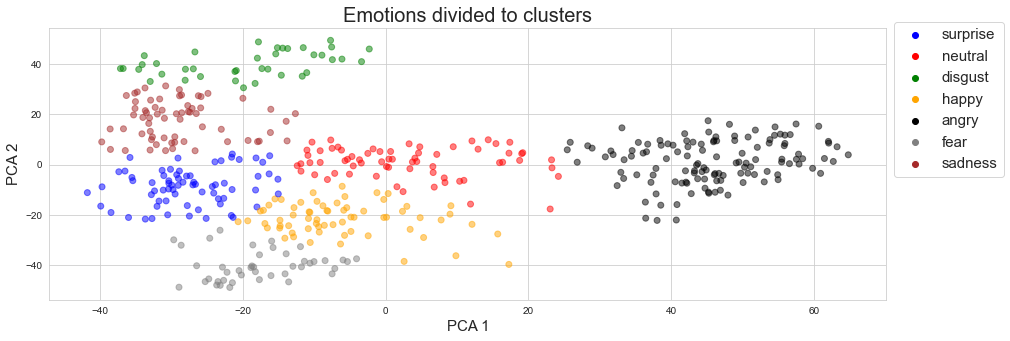

In [177]:
colors = {0:'blue', 1:'red', 2:'green', 3:'orange', 4:'black', 5:'grey', 6:'brown'}
lab = ['surprise', 'neutral', 'disgust', 'happy', 'angry', 'fear', 'sadness']


fig = plt.figure(figsize = (15, 5))
ax = fig.add_subplot(111)
ax.scatter(X_pca[:, 0], X_pca[:, 1], c = pd.Series(labels).map(colors), alpha=0.5)
for i in range(7):
    plt.scatter(None, None, color=colors[i], label=lab[i])

plt.title('Emotions divided to clusters', fontsize=20)
plt.legend(fontsize=15, bbox_to_anchor= [1, 1.05])
plt.xlabel('PCA 1', fontsize=15)
plt.ylabel('PCA 2', fontsize=15)
plt.show()

### Save models:

In [179]:
import tensorflow as tf

# model2.save('d://ITC//final_project_data//model2.h5')
# model3.save('D://emotion_recognition_data//model3.h5')

model3 = tf.keras.models.load_model('D://emotion_recognition_data//model3.h5')

In [174]:
emotion_enc

{'fear': 0,
 'disgust': 1,
 'neutral': 2,
 'happy': 3,
 'sadness': 4,
 'surprise': 5,
 'angry': 6}

#### Check random samples from dataset

In [264]:
x,sr = librosa.load('D://emotion_recognition_data//data//data//Actor_01//03-01-04-02-02-01-01.wav',
             res_type='kaiser_fast', sr=44000)

In [265]:
x.shape, length_chosen

((164432,), 120378)

In [266]:
if x.shape[0] > length_chosen:
        new = x[:length_chosen]
elif x.shape[0] < length_chosen:
        new = np.pad(x,math.ceil((length_chosen-x.shape[0])/2), mode='median')
else:
        new = x



In [267]:
mfcc = librosa.feature.mfcc(y=new, sr=44000, n_mfcc=40)
mfcc = mfcc.T
mfcc.shape

(236, 40)

In [268]:
mfcc = mfcc.reshape(1,236,40)
mfcc.shape
p = model3.predict(mfcc)

In [269]:
p.argmax()

4

In [270]:
emotion_enc

{'fear': 0,
 'disgust': 1,
 'neutral': 2,
 'happy': 3,
 'sadness': 4,
 'surprise': 5,
 'angry': 6}